# ARIMA Traffic Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import toeplitz
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data

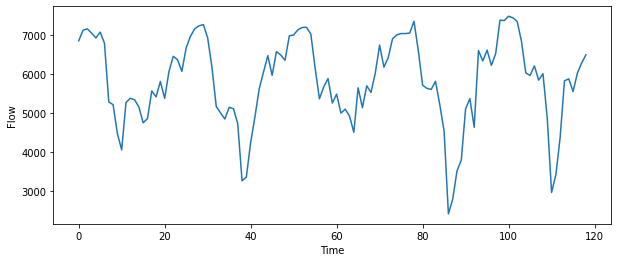

In [2]:
# Import Data
data = pd.read_csv("data.csv")
time = data.time[0:119]
flow = data.flow[0:119]

# Visualise
plt.figure(figsize=(10,4))
plt.plot(flow)
plt.xlabel("Time")
plt.ylabel("Flow")
plt.show()

## Check Stationarity

In [3]:
dftest = adfuller(flow, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -6.196500979049965
2. P-Value :  5.947669315210753e-08
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 108
5. Critical Values :
	 1% :  -3.4924012594942333
	 5% :  -2.8886968193364835
	 10% :  -2.5812552709190673


## Autocovariance Sequence

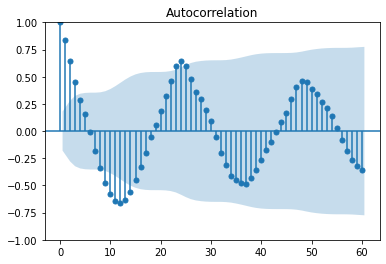

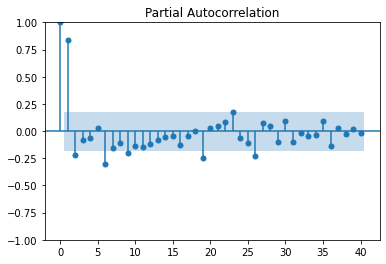

In [4]:
# Plot autocorrelation sequence
plot_acf(flow, lags=60)
plt.show()

# Plot partial autocorrelation sequence
plot_pacf(flow, lags=40, method='ywm')
plt.show()

## Choose Parameters for Seasonal ARIMA Model

In [5]:
def optimize_SARIMA(parameters_list, s, data):
    """
    Input:
        parameters_list - list with (P, D, Q) tuples
        s - length of season
        data - the exogenous variable
    Output:
        Return a dataframe with parameters and their corresponding AIC and SSE.        
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(data, 
                            order=(0, 0, 0), 
                            seasonal_order=(param[0], param[1], param[2], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(P, D, Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [6]:
from itertools import product
import warnings
warnings.filterwarnings("ignore")

P = range(0, 2, 1)
D = range(0, 2, 1)
Q = range(0, 3, 1)
s = 24

parameters_list = list(product(P,D,Q))

result_df = optimize_SARIMA(parameters_list, 24, flow)

# Ordered by AIC
result_df.head()

,"(P, D, Q)",AIC
0,"(1, 1, 1)",1500.521667
1,"(1, 1, 2)",1502.173157
2,"(1, 1, 0)",1508.472472
3,"(0, 1, 2)",1509.502138
4,"(0, 1, 1)",1512.883414


## Fit SARIMA Model

In [7]:
# Separate data into training and testing
index_train_data = 90
train_data = flow[: index_train_data]
test_data = flow[index_train_data :]

# define model
model = SARIMAX(train_data,
                order=(0,0,0),
                seasonal_order=(4,1,2,24))

#fit the model
model_fit = model.fit()
preds_df = (model_fit.get_prediction(start=index_train_data, end=119).summary_frame(alpha=0.05))

#summary of the model
print(model_fit.summary())

                                   SARIMAX Results                                   
Dep. Variable:                          flow   No. Observations:                   90
Model:             SARIMAX(4, 1, [1, 2], 24)   Log Likelihood                -523.003
Date:                       Mon, 26 Sep 2022   AIC                           1060.006
Time:                               23:53:46   BIC                           1075.334
Sample:                                    0   HQIC                          1066.063
                                        - 90                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       1.3488   5195.151      0.000      1.000   -1.02e+04    1.02e+04
ar.S.L48      -0.1202   3321.694  -3.62e-05      1.000   -6510.522    6510.

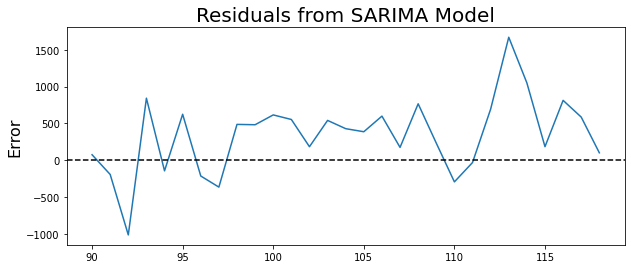

In [8]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

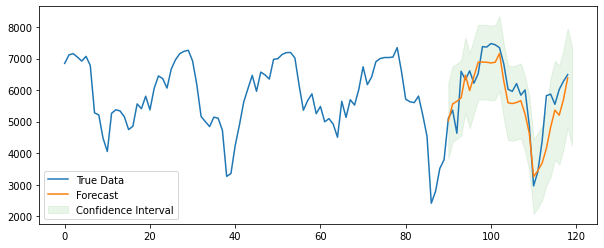

In [9]:
# Plot data and prediction
plt.figure(figsize=(10,4))
plt.plot(flow, label="True Data")
plt.plot(predictions, label="Forecast")
plt.fill_between(preds_df.index, 
                 preds_df['mean_ci_lower'], 
                 preds_df['mean_ci_upper'],
                 color='C2', 
                 alpha=0.1,
                 label="Confidence Interval")
plt.legend()
plt.show()